In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd

In [4]:
neighborhoods_gdf = gpd.read_file('neighbourhoods.geojson')

df = pd.read_csv("listings_detailed.csv", encoding='latin-1')
df = df.dropna()

In [5]:
import re
def split_and_clean_amenities(amenities_str):
    amenities = amenities_str.strip('{}').split(',')
    cleaned_amenities = [amenity.strip() for amenity in amenities]
    return set(cleaned_amenities)

df['amenities'] = df['amenities'].apply(split_and_clean_amenities)

unique_amenities = set([amenity for amenities in df['amenities'] for amenity in amenities])


for amenity in unique_amenities:
    df[amenity] = df['amenities'].apply(lambda x: 1 if amenity in x else 0)

df.drop('amenities', axis=1, inplace=True)

print(df)

      price  neighbourhood_cleansed zipcode  latitude  longitude  \
0       853               Norrmalms   11347  59.34342   18.05298   
1      1079              Skarpnäcks   12838  59.27054   18.11231   
2      1285              Södermalms  118 53  59.31364   18.05256   
4      3247              Södermalms   11739  59.31535   18.03277   
5       598              Södermalms   11864  59.31268   18.06258   
...     ...                     ...     ...       ...        ...   
7849    196          Rinkeby-Tensta  163 74  59.38766   17.93615   
7850    549      Hässelby-Vällingby  165 66  59.36233   17.83382   
7851   1001  Hägersten-Liljeholmens  117 68  59.31533   17.99404   
7852   2295              Östermalms  115 47  59.35901   18.09062   
7853    353          Rinkeby-Tensta  164 53  59.40433   17.94475   

     is_location_exact       property_type        room_type  accommodates  \
0                    t           Apartment     Private room             2   
1                    t   Bed 

C:\Users\claud\AppData\Local\Temp\ipykernel_24112\493287171.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[amenity] = df['amenities'].apply(lambda x: 1 if amenity in x else 0)
C:\Users\claud\AppData\Local\Temp\ipykernel_24112\493287171.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[amenity] = df['amenities'].apply(lambda x: 1 if amenity in x else 0)
C:\Users\claud\AppData\Local\Temp\ipykernel_24112\493287171.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

In [6]:
percentile_95 = df["price"].quantile(0.95)
df = df[df["price"] < percentile_95]

In [12]:
chunk_size = 10000
chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

result_df = pd.DataFrame()

for chunk in chunks:
    merged_chunk = neighborhoods_gdf.merge(chunk, left_on='neighbourhood', right_on='neighbourhood_cleansed')

    result_df = pd.concat([result_df, merged_chunk], ignore_index=True)

average_prices = result_df.groupby('neighbourhood')['price'].mean().reset_index()

In [14]:
neighborhoods_gdf = neighborhoods_gdf.merge(average_prices, on='neighbourhood')

In [15]:
print(neighborhoods_gdf)

             neighbourhood  neighbourhood_group  \
0             Kungsholmens                  NaN   
1               Östermalms                  NaN   
2                   Bromma                  NaN   
3              Skärholmens                  NaN   
4               Södermalms                  NaN   
5   Hägersten-Liljeholmens                  NaN   
6                Norrmalms                  NaN   
7                   Farsta                  NaN   
8       Hässelby-Vällingby                  NaN   
9               Skarpnäcks                  NaN   
10           Spånga-Tensta                  NaN   
11                  Älvsjö                  NaN   
12   Enskede-Årsta-Vantörs                  NaN   
13          Rinkeby-Tensta                  NaN   

                                             geometry        price  
0   MULTIPOLYGON (((17.97420 59.31400, 17.97834 59...   949.385787  
1   MULTIPOLYGON (((18.03773 59.37062, 18.03850 59...  1018.171472  
2   MULTIPOLYGON (((17.8646

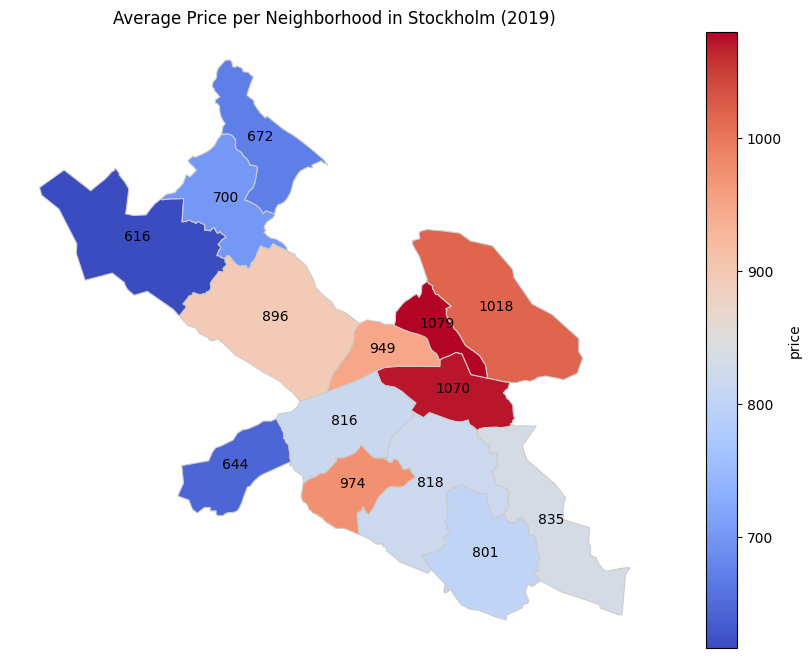

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
neighborhoods_gdf.plot(column='price', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.set_title('Average Price per Neighborhood in Stockholm (2019)')

ax.axis('off')

sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=neighborhoods_gdf['price'].min(), vmax=neighborhoods_gdf['price'].max()))
sm._A = []
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('price')

for idx, row in neighborhoods_gdf.iterrows():
    plt.annotate(text=str(int(row['price'])), xy=row['geometry'].centroid.coords[0], ha='center', fontsize=10, color='black')


plt.savefig('stockholm_neighborhoods_map_avg.png', bbox_inches='tight')
plt.show()


In [38]:
chunk_size = 10000
chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

result_df = pd.DataFrame()

for chunk in chunks:
    merged_chunk = neighborhoods_gdf.merge(chunk, left_on='neighbourhood', right_on='neighbourhood_cleansed')

    result_df = pd.concat([result_df, merged_chunk], ignore_index=True)

listings_count = result_df['neighbourhood'].value_counts().reset_index()
listings_count.columns = ['neighbourhood', 'Listings_Count']

In [40]:
neighborhoods_gdf = neighborhoods_gdf.merge(listings_count, on='neighbourhood')

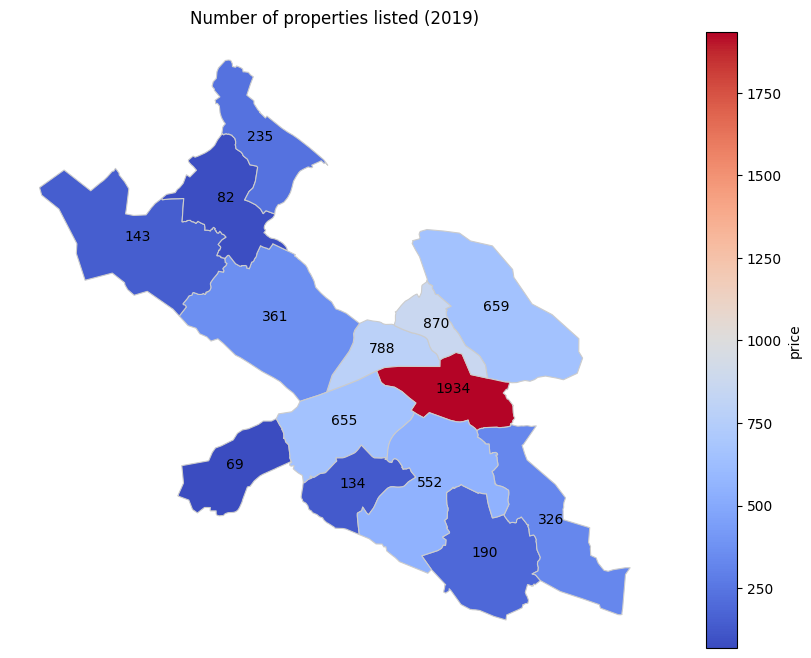

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
neighborhoods_gdf.plot(column='Listings_Count', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.set_title('Number of properties listed (2019)')

ax.axis('off')

sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=neighborhoods_gdf['Listings_Count'].min(), vmax=neighborhoods_gdf['Listings_Count'].max()))
sm._A = []
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('price')

for idx, row in neighborhoods_gdf.iterrows():
    plt.annotate(text=str(int(row['Listings_Count'])), xy=row['geometry'].centroid.coords[0], ha='center', fontsize=10, color='black')

plt.savefig('stockholm_neighborhoods_map_cnt.png', bbox_inches='tight')
plt.show()

